## Netflix Subscription Forecasting
This project aim estimate the expected number of subscriber of Netflix in the given period through ARIMA and SARIMA model and present in-depth analysis.

### 1. Data Processing

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import sys
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('Data/Netflix-Subscriptions.csv')
df.head()

,Time Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


The dataset contain netflix quarterly subscription data from 2013 to 2023. Before first step analysis, we need to convert the time period data from str to datetime format.

In [3]:
df['Date'] = pd.to_datetime(df['Time Period'],format='%d/%m/%Y')
df.head()

,Time Period,Subscribers,Date
0,01/04/2013,34240000,2013-04-01
1,01/07/2013,35640000,2013-07-01
2,01/10/2013,38010000,2013-10-01
3,01/01/2014,41430000,2014-01-01
4,01/04/2014,46130000,2014-04-01


### 2. Exploratory Data Analysis

In [4]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],
                         y=df['Subscribers'],
                         mode='lines', name='Subscribers'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                  xaxis_title='Date',
                  yaxis_title='Netflix Subscriptions')
fig.show()

#### 2.1 Seasonality:

In [5]:
df['Quarterly Growth Rate'] = df['Subscribers'].pct_change() * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
df['Bar Color'] = df['Quarterly Growth Rate'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df['Date'],
    y=df['Quarterly Growth Rate'],
    marker_color=df['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)')
fig.show()
     

Next, we use seasonal_decompose to confirm the assumption of seasonlity.

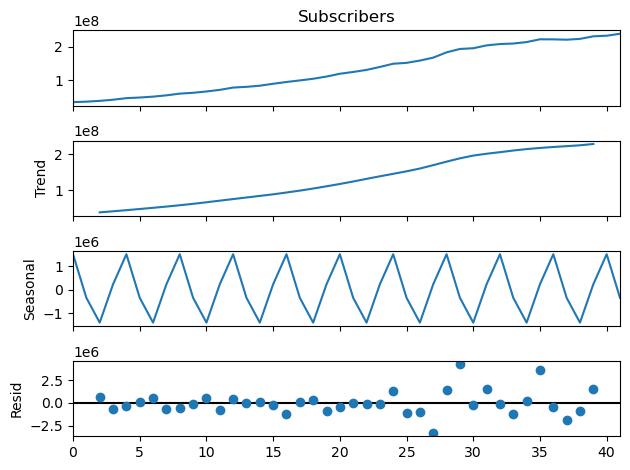

In [6]:
decomposition = seasonal_decompose(df['Subscribers'],
                                   model = 'additive',
                                   period = 4)
decomposition.plot()
plt.show()


From graphs above, we are able to confirm our suspicious of seasonality. Therefore, SARIMA instead of ARIAM should be adopted to analyze the data.



#### 2.2 Stationarity


In [7]:
time_series = df.set_index('Date')['Subscribers']


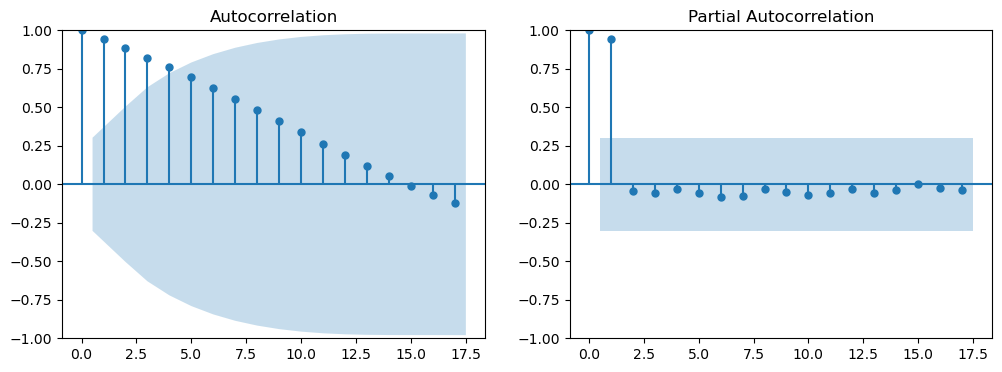

In [8]:
original_series = time_series.dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(original_series, ax=axes[0])
plot_pacf(original_series, ax=axes[1])
plt.show()


From ACF and PACF graph generated based on original subscriber data, it shows an obivious non-stationary characteristics. Therefore, differencing should be done to achieve stationarity.

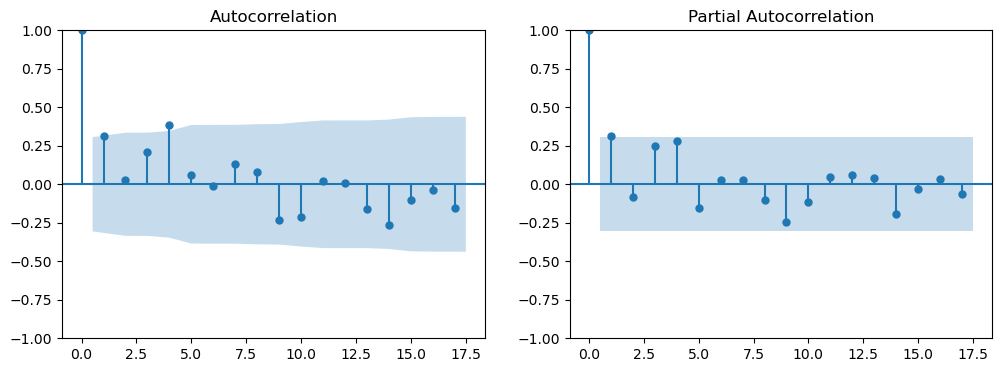

In [9]:
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

### 3. Modeling
To start modeling, we need to convert data into time series format and split the training/test set. For the limited length of the data, we will use data prior to 2022 as training set and 2023 data as testing set.

In [10]:
train = differenced_series.iloc[:-6]
test = differenced_series.iloc[-6:]

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],
                         y=differenced_series,
                         mode='lines', name='Training'))
fig.add_trace(go.Scatter(x=df['Date'][-7:],
                         y=test,
                         mode='lines', name='Testing'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                  xaxis_title='Date',
                  yaxis_title='SubscriptionGrowth')

fig.show()

In [95]:
model = SARIMAX(train,order = (1,1,1), seasonal_order=(0,1,0,4))
model = model.fit()
prediction  =model.predict(start=len(train), end=len(train) + len(test) - 1)

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



In [99]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'],
                         y=differenced_series,
                         mode='lines', name='Training'))
fig.add_trace(go.Scatter(x=df['Date'][-7:],
                         y=test,
                         mode='lines', name='Testing'))
fig.add_trace(go.Scatter(x=df['Date'][-7:],
                         y=prediction,
                         mode='lines', name='predicted'))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth',
                  xaxis_title='Date',
                  yaxis_title='Subscription Growth')

fig.show()

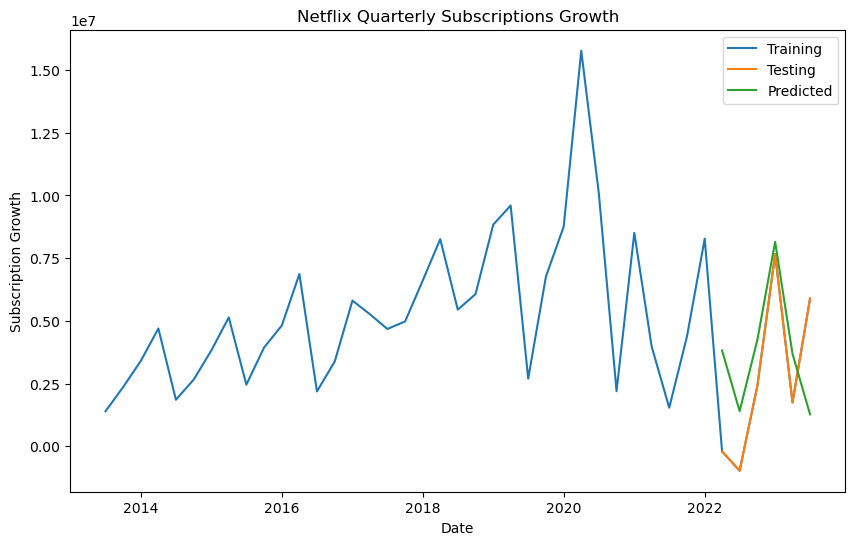

In [102]:
#Plt was utlized for its compatability with Github graph
plt.figure(figsize=(10, 6))

# Plot the training data
plt.plot(df['Date'][1:], differenced_series, label='Training', linestyle='-', marker=None)

# Plot the testing data
plt.plot(df['Date'][-6:], test, label='Testing', linestyle='-', marker=None)

# Plot the predicted data
plt.plot(df['Date'][-6:], prediction, label='Predicted', linestyle='-', marker=None)

# Adding title and labels
plt.title('Netflix Quarterly Subscriptions Growth')
plt.xlabel('Date')
plt.ylabel('Subscription Growth')

plt.legend()

plt.show()

From the graph above, we can see the SARIMA capture the seasonality and overall trend of growth.

### Limit of ARIMA: 

The model assumes the future resemble the past. Therefore, it might fail when there are external force that interrupting the market like financial crisis or growth new business model in the market.